In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
from requests.exceptions import Timeout
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [73]:
class TripFilter( BaseEstimator, TransformerMixin):
  
  def __init__(self, month_pointer, path_to_temp):
    self.month_pointer = month_pointer
    self.path_to_temp = path_to_temp

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    print(f"****************************Trip Filtering {self.month_pointer}")
    gps_data,bus_trips,trip_ends = X

    split_points_path = "../../data/Raw-GPS-data-Kandy-Buses/MAIN/TEMP/SPLIT_POINTS/segment_split_points.csv"
    split_points_df = pd.read_csv(split_points_path)

    out = []

    for index, row in bus_trips.iterrows():
      # print("Procesing ",row['trip_id'] )
      if row['direction']==1:
        buff = split_points_df[::].copy()
      else:
        buff = split_points_df[::-1].reset_index(drop=True).copy()
      max_index = np.max(np.where(gps_data['trip_id'] == row['trip_id']))
      min_index = np.min(np.where(gps_data['trip_id'] == row['trip_id']))

      acc_dis, count = 0, 0
      per_count = (max_index-min_index+1) // len(buff)
  
      for ind, row_buff in buff.iterrows():
         buff_gps = (row_buff['latitude'], row_buff['longitude'])
        #  print(f"Processing buff ind: {ind} through range {ind*per_count + min_index}-{min_index+(ind+1)*per_count}")
         for i in range(min_index+ ind*per_count, min_index+ ind*per_count+ (5 if per_count>5 else per_count)):
            try:
              gps = (gps_data.loc[i]['latitude'], gps_data.loc[i]['longitude'])
              acc_dis += geodesic(buff_gps, gps).meters
              count += 1
            except KeyError:
               print(f"key error occured! trip ID: {row['trip_id']}")

      out.append({"no_of_points": max_index-min_index+1, 'trip_id': row['trip_id'], 'kernel_value': acc_dis/count if count>0 else np.nan})

    df = pd.DataFrame(out)
    trip_ids_below_threshold = set(df[df['no_of_points']<50]['trip_id'])
    trip_ids_not_in_route = set(df[(df['kernel_value']>2200)]['trip_id'])

    all = trip_ids_below_threshold.union(trip_ids_not_in_route)
    print(f"Dropping {len(all)} trips")

    # drop the trips which has low number of points than specified threshold
    gps_data = gps_data.drop(gps_data[gps_data.trip_id.isin(trip_ids_below_threshold)].index)
    bus_trips = bus_trips.drop(bus_trips[bus_trips.trip_id.isin(trip_ids_below_threshold)].index)
    trip_ends = trip_ends.drop(trip_ends[trip_ends.trip_id.isin(trip_ids_below_threshold)].index)


    # drops the trips that are not driven in the focussed route
    gps_data = gps_data.drop(gps_data[gps_data.trip_id.isin(trip_ids_not_in_route)].index)
    bus_trips = bus_trips.drop(bus_trips[bus_trips.trip_id.isin(trip_ids_not_in_route)].index)
    trip_ends = trip_ends.drop(trip_ends[trip_ends.trip_id.isin(trip_ids_not_in_route)].index)

    gps_data.reset_index(drop=True, inplace=True)
    bus_trips.reset_index(drop=True, inplace=True)
    trip_ends.reset_index(drop=True, inplace=True)

    return gps_data, bus_trips, trip_ends

In [74]:
path_trips = "../../data/Raw-GPS-data-Kandy-Buses/MAIN/TEMP/TR_EX/digana_2021_10_bus_trips.csv"
path_gps = "../../data/Raw-GPS-data-Kandy-Buses/MAIN/TEMP/TR_EX/digana_2021_10_gps_data.csv"
path_trip_ends = "../../data/Raw-GPS-data-Kandy-Buses/MAIN/TEMP/TR_EX/digana_2021_10_trip_ends.csv"

gps_data_r = pd.read_csv(path_gps)
bus_trips_r = pd.read_csv(path_trips)
trip_ends_r = pd.read_csv(path_trip_ends)
filter = TripFilter("", "")
res = filter.fit_transform((gps_data_r, bus_trips_r,trip_ends_r))

****************************Trip Filtering 
Dropping 77 trips


In [75]:
gps_data = res[0]
out_temp = res[3]

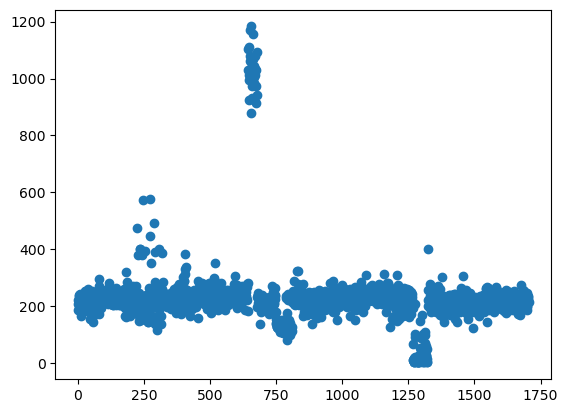

In [41]:
plt.scatter([x for x in range(len(out_temp))], out_temp['no_of_points'])
plt.show()

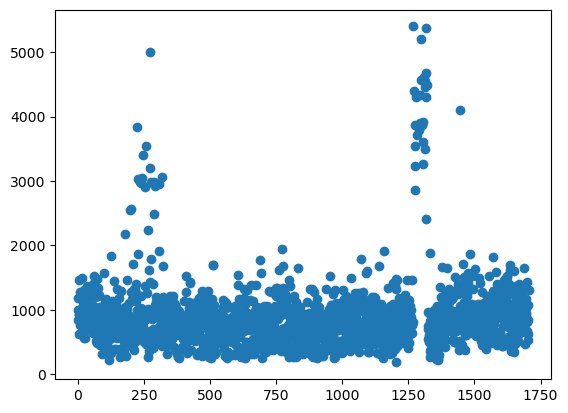

In [42]:
plt.scatter([x for x in range(len(out_temp))], out_temp['kernel_value'])
plt.show()

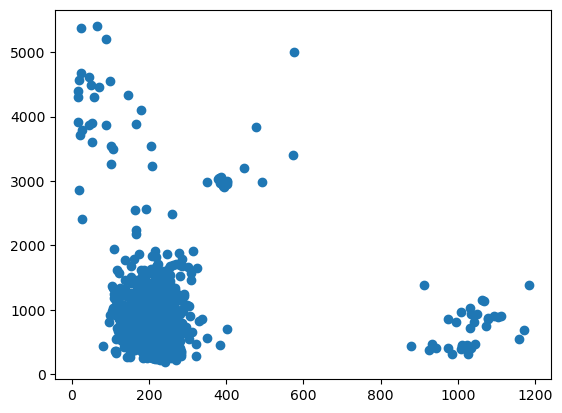

In [65]:
plt.scatter(out_temp['no_of_points'], out_temp['kernel_value'])
plt.show()

In [55]:
res[(res['kernel_value']>2800) & (res['no_of_points']>250)]

,no_of_points,trip_id,kernel_value
223,476,224.0,3838.897834
229,379,230.0,3030.275729
235,401,236.0,2988.785995
237,401,238.0,2997.826255
239,383,240.0,2962.666503
242,381,243.0,3045.858906
248,572,249.0,3401.470065
253,394,254.0,2913.010087
272,447,273.0,3200.793530
275,576,276.0,4995.559494


In [ ]:

# Function to get two random rows from each group
def sample_two_rows(group):
    return group.sample(n=2)

def get_sample(df):
    # Applying the function to each group
    result_df = df.groupby('trip_id', group_keys=False).apply(sample_two_rows)

    # Resetting the index of the result DataFrame
    result_df.reset_index(drop=True, inplace=True)

    # Displaying the result DataFrame
    return result_df


In [27]:
counts = gps_data.groupby("trip_id").count()
counts[counts['id']<50]

,id,deviceid,devicetime,latitude,longitude,speed,date,time
trip_id,,,,,,,,


In [76]:
gps_sample = get_sample(gps_data)

In [77]:
import folium
should_plot = gps_sample
df = should_plot

# Create a folium map centered around the mean of latitudes and longitudes
map_center = [df['latitude'].mean(), df['longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=13)

# Add markers for each row in the DataFrame
for index, row in df.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']]).add_to(mymap)

# # Add markers for each row in the DataFrame
# for index, row in segment.iterrows():
#     folium.Marker(location=[row['latitude'], row['longitude']], icon=folium.Icon(color="green")).add_to(mymap)

# Save the map as an HTML file
mymap.save("map.html")

In [64]:
k = pd.DataFrame({"name": ['kas', 'pav', 'sup', 'nad', 'mad', 'mud'], 'age': [1, 2, 3,4 ,5,6]})

In [66]:
k[k['age']!= [1,2]]

ValueError: ('Lengths must match to compare', (6,), (2,))